In [71]:
# Import all necessary packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from yellowbrick.model_selection import FeatureImportances

## Dataset :

In [73]:
df = pd.read_csv(r'D:\Chindhu\RoadMap for Career\Data Science\Guvi\Python Codes\Final Projects\hospital_readmissions\hospital_readmissions.csv')

In [74]:
df.head()

,Patient_ID,Age,Gender,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
0,1,69,Other,Emergency,Heart Disease,33,2,4,1,1,5,NaN,Yes
1,2,32,Female,Urgent,Diabetes,81,10,4,4,1,6,NaN,No
2,3,78,Female,Urgent,Heart Disease,75,29,4,0,3,5,Normal,No
3,4,38,Male,Elective,Diabetes,77,11,2,3,4,9,NaN,Yes
4,5,41,Female,Urgent,Diabetes,50,25,3,4,1,3,NaN,Yes


In [75]:
df.shape

(1000, 13)

## Data Cleaning :

In [77]:
df.isnull().sum() # No null values except the A1C column, which we are planning to omit as null values are high

Patient_ID                 0
Age                        0
Gender                     0
Admission_Type             0
Diagnosis                  0
Num_Lab_Procedures         0
Num_Medications            0
Num_Outpatient_Visits      0
Num_Inpatient_Visits       0
Num_Emergency_Visits       0
Num_Diagnoses              0
A1C_Result               434
Readmitted                 0
dtype: int64

<Axes: xlabel='Age'>

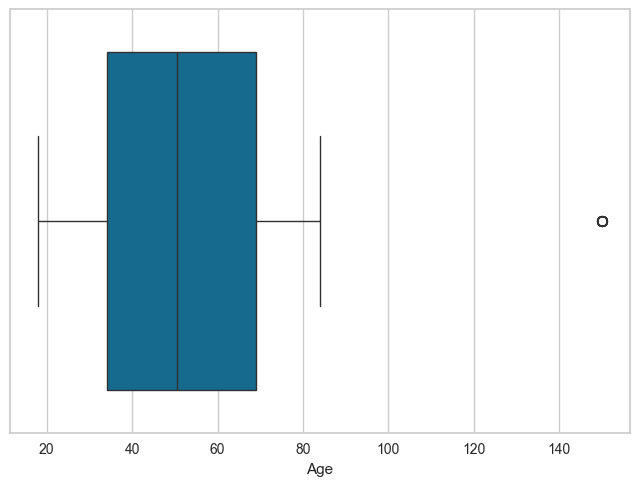

In [80]:
sns.boxplot(x=df['Age']) # Outlier detected in column "Age"

In [81]:
q1=df['Age'].quantile(0.25)
print("Q1="+str(q1))
q3=df['Age'].quantile(0.75)
print("Q3="+str(q3))
iqr=q3-q1
print("IQR="+str(iqr))
lower=q1-1.5*iqr
print("Lower="+str(lower))
upper=q3+1.5*iqr
print("Upper="+str(upper))

Q1=34.0
Q3=69.0
IQR=35.0
Lower=-18.5
Upper=121.5


In [85]:
outlier=((df['Age']<lower)|(df['Age']>upper))
outlier_detected=df[outlier]
print(outlier_detected.shape)
outlier_detected #As 90% the patients are getting readmitted with Age=150(outlier). Also, it abnormal for a person to have Age = 150. 

(10, 13)


,Patient_ID,Age,Gender,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
50,51,150,Other,Urgent,Diabetes,88,10,4,3,4,5,Abnormal,Yes
51,52,150,Other,Emergency,Diabetes,86,22,1,2,3,2,Abnormal,Yes
52,53,150,Female,Urgent,Injury,93,19,0,1,3,8,Normal,Yes
53,54,150,Female,Elective,Diabetes,86,1,1,0,4,9,Normal,Yes
54,55,150,Other,Elective,Diabetes,44,7,3,3,4,4,NaN,Yes
55,56,150,Other,Elective,Diabetes,9,4,2,4,0,6,Normal,Yes
56,57,150,Female,Emergency,Diabetes,37,1,1,2,4,8,Abnormal,Yes
57,58,150,Female,Urgent,Injury,74,15,2,0,3,9,Abnormal,Yes
58,59,150,Male,Emergency,Diabetes,36,8,0,4,4,5,Normal,No
59,60,150,Male,Urgent,Infection,92,12,4,4,0,6,Abnormal,Yes


In [86]:
outlier_removed=df[~outlier] # let's drop these columns, whose age = 150
print(outlier_removed.shape)
outlier_removed

(990, 13)


,Patient_ID,Age,Gender,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
0,1,69,Other,Emergency,Heart Disease,33,2,4,1,1,5,NaN,Yes
1,2,32,Female,Urgent,Diabetes,81,10,4,4,1,6,NaN,No
2,3,78,Female,Urgent,Heart Disease,75,29,4,0,3,5,Normal,No
3,4,38,Male,Elective,Diabetes,77,11,2,3,4,9,NaN,Yes
4,5,41,Female,Urgent,Diabetes,50,25,3,4,1,3,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,21,Female,Emergency,Heart Disease,68,10,2,3,2,9,Normal,No
996,997,43,Female,Emergency,Heart Disease,61,7,0,4,0,1,Normal,No
997,998,75,Male,Urgent,Diabetes,29,13,3,1,4,8,Normal,No
998,999,46,Other,Elective,Injury,19,20,1,4,4,1,Abnormal,No


In [87]:
outlier_removed.to_csv(r'df_1.csv',index=False)

In [88]:
df=pd.read_csv(r'df_1.csv')

<Axes: xlabel='Num_Lab_Procedures'>

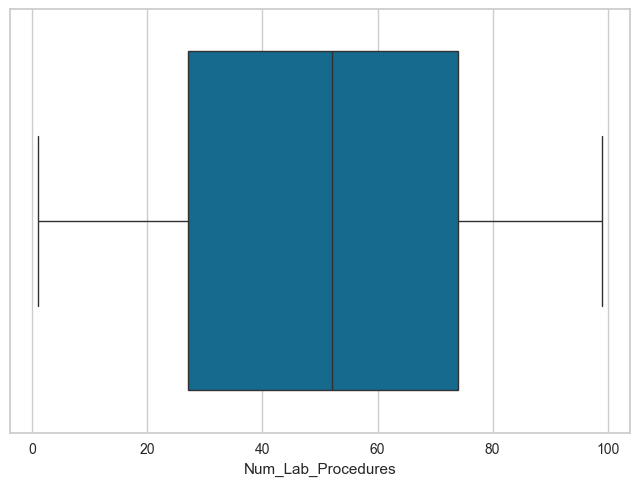

In [89]:
sns.boxplot(x=df['Num_Lab_Procedures']) # No outlier

<Axes: xlabel='Num_Medications'>

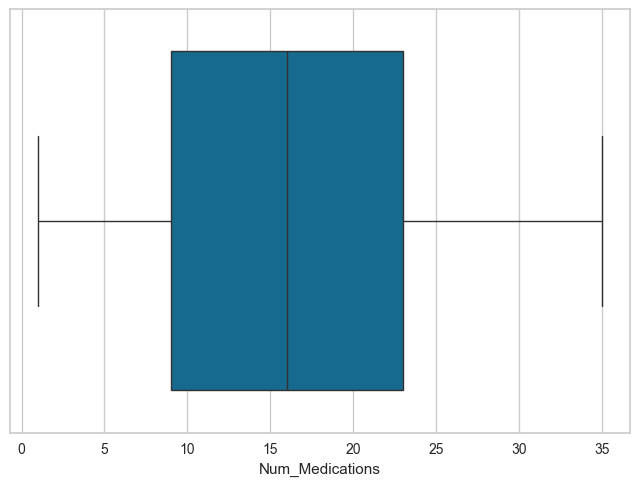

In [90]:
sns.boxplot(x=df['Num_Medications']) # No outlier

<Axes: xlabel='Num_Outpatient_Visits'>

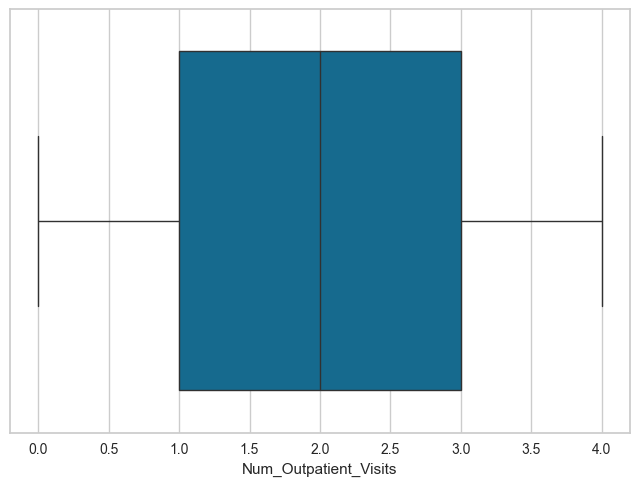

In [91]:
sns.boxplot(x=df['Num_Outpatient_Visits']) # No outlier

<Axes: xlabel='Num_Inpatient_Visits'>

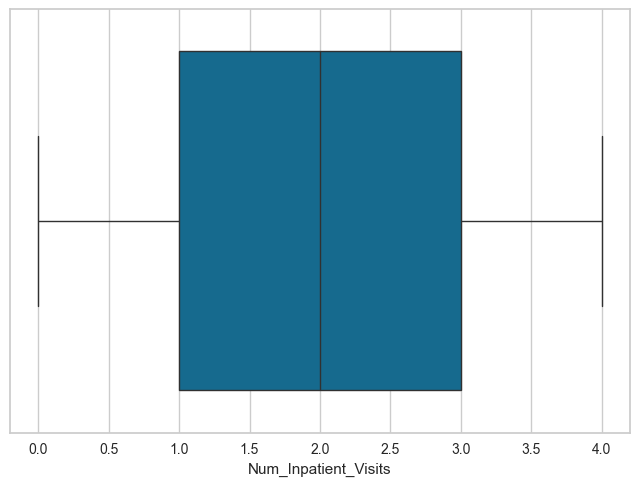

In [92]:
sns.boxplot(x=df['Num_Inpatient_Visits']) # No outlier

<Axes: xlabel='Num_Emergency_Visits'>

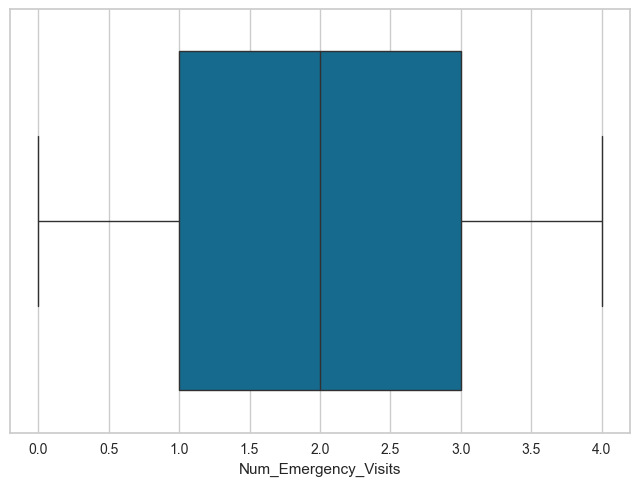

In [93]:
sns.boxplot(x=df['Num_Emergency_Visits']) # No outlier

<Axes: xlabel='Num_Diagnoses'>

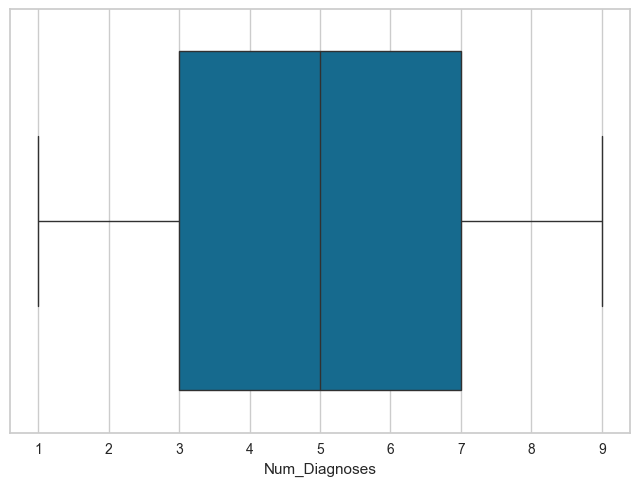

In [94]:
sns.boxplot(x=df['Num_Diagnoses']) # No outlier

In [95]:
df['Gender'].value_counts()

Gender
Male      344
Female    333
Other     313
Name: count, dtype: int64

In [96]:
df['Admission_Type'].value_counts()

Admission_Type
Elective     342
Emergency    334
Urgent       314
Name: count, dtype: int64

In [97]:
df['Diagnosis'].value_counts()

Diagnosis
Diabetes         265
Infection        246
Injury           242
Heart Disease    237
Name: count, dtype: int64

In [99]:
df['Readmitted'].value_counts() # Slight data imbalance, need to handle them

Readmitted
No     502
Yes    488
Name: count, dtype: int64

In [100]:
clean_df=pd.read_csv(r'df_1.csv')

In [101]:
clean_df

,Patient_ID,Age,Gender,Admission_Type,Diagnosis,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Readmitted
0,1,69,Other,Emergency,Heart Disease,33,2,4,1,1,5,NaN,Yes
1,2,32,Female,Urgent,Diabetes,81,10,4,4,1,6,NaN,No
2,3,78,Female,Urgent,Heart Disease,75,29,4,0,3,5,Normal,No
3,4,38,Male,Elective,Diabetes,77,11,2,3,4,9,NaN,Yes
4,5,41,Female,Urgent,Diabetes,50,25,3,4,1,3,NaN,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,996,21,Female,Emergency,Heart Disease,68,10,2,3,2,9,Normal,No
986,997,43,Female,Emergency,Heart Disease,61,7,0,4,0,1,Normal,No
987,998,75,Male,Urgent,Diabetes,29,13,3,1,4,8,Normal,No
988,999,46,Other,Elective,Injury,19,20,1,4,4,1,Abnormal,No


In [102]:
clean_encode_df = pd.get_dummies(clean_df, columns = ['Gender', 'Admission_Type','Diagnosis','Readmitted']) 
clean_encode_df.columns

Index(['Patient_ID', 'Age', 'Num_Lab_Procedures', 'Num_Medications',
       'Num_Outpatient_Visits', 'Num_Inpatient_Visits', 'Num_Emergency_Visits',
       'Num_Diagnoses', 'A1C_Result', 'Gender_Female', 'Gender_Male',
       'Gender_Other', 'Admission_Type_Elective', 'Admission_Type_Emergency',
       'Admission_Type_Urgent', 'Diagnosis_Diabetes',
       'Diagnosis_Heart Disease', 'Diagnosis_Infection', 'Diagnosis_Injury',
       'Readmitted_No', 'Readmitted_Yes'],
      dtype='object')

In [103]:
columns_to_convert = ['Gender_Female', 'Gender_Male', 'Gender_Other','Admission_Type_Elective','Admission_Type_Emergency','Admission_Type_Urgent','Diagnosis_Diabetes','Diagnosis_Heart Disease','Diagnosis_Infection','Diagnosis_Injury','Readmitted_No','Readmitted_Yes']
for column in columns_to_convert:
    clean_encode_df[column] = clean_encode_df[column].astype(int)

In [104]:
clean_encode_df.to_csv(r'df_2.csv',index=False)
clean_encode_df.head()

,Patient_ID,Age,Num_Lab_Procedures,Num_Medications,Num_Outpatient_Visits,Num_Inpatient_Visits,Num_Emergency_Visits,Num_Diagnoses,A1C_Result,Gender_Female,...,Gender_Other,Admission_Type_Elective,Admission_Type_Emergency,Admission_Type_Urgent,Diagnosis_Diabetes,Diagnosis_Heart Disease,Diagnosis_Infection,Diagnosis_Injury,Readmitted_No,Readmitted_Yes
0,1,69,33,2,4,1,1,5,NaN,0,...,1,0,1,0,0,1,0,0,0,1
1,2,32,81,10,4,4,1,6,NaN,1,...,0,0,0,1,1,0,0,0,1,0
2,3,78,75,29,4,0,3,5,Normal,1,...,0,0,0,1,0,1,0,0,1,0
3,4,38,77,11,2,3,4,9,NaN,0,...,0,1,0,0,1,0,0,0,0,1
4,5,41,50,25,3,4,1,3,NaN,1,...,0,0,0,1,1,0,0,0,0,1


## Model Building :

In [105]:
df=pd.read_csv(r'df_2.csv')

#### train_test split :

In [106]:
X = df.iloc[:,[1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18]] #17 independent column_names = ['Age', 'Num_Lab_Procedures', 'Num_Medications','Num_Outpatient_Visits','Num_Inpatient_Visits','Num_Emergency_Visits','Num_Diagnoses','Gender_Female','Gender_Male','Gender_Other','Admission_Type_Elective','Admission_Type_Emergency','Admission_Type_Urgent','Diagnosis_Diabetes','Diagnosis_Heart Disease','Diagnosis_Infection','Diagnosis_Injury'] 
y = df.iloc[:, 20].ravel() #1 dependent column = ['Readmission_Yes']

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### SMOTE :

In [108]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
sm = SMOTE(random_state = 2) 
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote == 0))) 

Before OverSampling, counts of label '1': 389
Before OverSampling, counts of label '0': 403 

After OverSampling, the shape of train_X: (806, 17)
After OverSampling, the shape of train_y: (806,) 

After OverSampling, counts of label '1': 403
After OverSampling, counts of label '0': 403


#### Scaling :

In [109]:
scaler = StandardScaler()
scaler.fit_transform(X_train_smote)
scaler.fit(X_test)

StandardScaler()

#### PCA :

In [110]:
n_components = 5  # Chose the number of components by hit and trial based on the training and testing accuracy
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_smote)
X_test_pca = pca.transform(X_test)

In [111]:
# Creating dataframes for testing and training evaluation metrics
training_eval_df=pd.DataFrame(columns=['Model','Accuracy','Recall','Precision','F1-Score','AUC'])
testing_eval_df=pd.DataFrame(columns=['Model','Accuracy','Recall','Precision','F1-Score','AUC'])

#### Logistic Regression :

In [112]:
clf1=LogisticRegression(random_state=42,max_iter=1000)
clf1.fit(X_train_pca, y_train_smote)

LogisticRegression(max_iter=1000, random_state=42)

In [113]:
# Training Evaluation
y_train_pred = clf1.predict(X_train_pca)

accuracy = accuracy_score(y_train_pred,y_train_smote)
precision = precision_score(y_train_pred,y_train_smote)
recall = recall_score(y_train_pred,y_train_smote)
f1_score_value = f1_score(y_train_pred,y_train_smote)

fpr, tpr, thresholds= roc_curve(y_train_pred,y_train_smote)
auc_roc= auc(fpr, tpr)

training_eval_df.loc[len(training_eval_df.index)] = ['Logistic Regression', accuracy, precision, recall, f1_score_value, auc_roc]  

In [114]:
# Testing Evaluation
y_test_pred = clf1.predict(X_test_pca)

accuracy = accuracy_score(y_test_pred,y_test)
precision = precision_score(y_test_pred,y_test)
recall = recall_score(y_test_pred,y_test)
f1_score_value = f1_score(y_test_pred,y_test)

fpr, tpr, thresholds= roc_curve(y_test_pred,y_test)
auc_roc= auc(fpr, tpr)

testing_eval_df.loc[len(testing_eval_df.index)] = ['Logistic Regression', accuracy, precision, recall, f1_score_value, auc_roc]  

#### KNN : 

In [115]:
# Choosing the value of K
K = [] 
training = [] 
test = [] 
scores = {} 
  
for k in range(2, 21): 
    clf2 = KNeighborsClassifier(n_neighbors = k) 
    clf2.fit(X_train_pca, y_train_smote) 
  
    training_score = clf2.score(X_train_pca, y_train_smote) 
    test_score = clf2.score(X_test_pca, y_test) 
    K.append(k) 
  
    training.append(training_score) 
    test.append(test_score) 
    scores[k] = [training_score, test_score] 
    
for keys, values in scores.items(): 
    print(keys, ':', values) 

2 : [0.7791563275434243, 0.4797979797979798]
3 : [0.7667493796526055, 0.4797979797979798]
4 : [0.6972704714640199, 0.4898989898989899]
5 : [0.728287841191067, 0.4898989898989899]
6 : [0.6960297766749379, 0.46464646464646464]
7 : [0.6985111662531017, 0.47474747474747475]
8 : [0.6699751861042184, 0.4898989898989899]
9 : [0.6625310173697271, 0.5050505050505051]
10 : [0.6439205955334988, 0.5404040404040404]
11 : [0.6513647642679901, 0.5202020202020202]
12 : [0.6377171215880894, 0.494949494949495]
13 : [0.6575682382133995, 0.51010101010101]
14 : [0.6513647642679901, 0.45454545454545453]
15 : [0.6426799007444168, 0.4595959595959596]
16 : [0.6327543424317618, 0.4595959595959596]
17 : [0.6290322580645161, 0.4595959595959596]
18 : [0.6290322580645161, 0.4595959595959596]
19 : [0.6129032258064516, 0.4797979797979798]
20 : [0.6004962779156328, 0.5]


In [116]:
clf2 = KNeighborsClassifier(n_neighbors = 10) #Choosing k=10, as the training and testing scores are good.
clf2.fit(X_train_pca, y_train_smote)

KNeighborsClassifier(n_neighbors=10)

In [117]:
# Training Evaluation
y_train_pred = clf2.predict(X_train_pca)

accuracy = accuracy_score(y_train_pred,y_train_smote)
precision = precision_score(y_train_pred,y_train_smote)
recall = recall_score(y_train_pred,y_train_smote)
f1_score_value = f1_score(y_train_pred,y_train_smote)

fpr, tpr, thresholds= roc_curve(y_train_pred,y_train_smote)
auc_roc= auc(fpr, tpr)

training_eval_df.loc[len(training_eval_df.index)] = ['KNN', accuracy, precision, recall, f1_score_value, auc_roc] 

In [118]:
# Testing Evaluation
y_test_pred = clf2.predict(X_test_pca)

accuracy = accuracy_score(y_test_pred,y_test)
precision = precision_score(y_test_pred,y_test)
recall = recall_score(y_test_pred,y_test)
f1_score_value = f1_score(y_test_pred,y_test)

fpr, tpr, thresholds= roc_curve(y_test_pred,y_test)
auc_roc= auc(fpr, tpr)

testing_eval_df.loc[len(testing_eval_df.index)] = ['KNN', accuracy, precision, recall, f1_score_value, auc_roc]

#### SVM :

In [119]:
clf3=SVC(random_state=0)
clf3.fit(X_train_pca,y_train_smote)

SVC(random_state=0)

In [120]:
# Training Evaluation
y_train_pred = clf3.predict(X_train_pca)

accuracy = accuracy_score(y_train_pred,y_train_smote)
precision = precision_score(y_train_pred,y_train_smote)
recall = recall_score(y_train_pred,y_train_smote)
f1_score_value = f1_score(y_train_pred,y_train_smote)

fpr, tpr, thresholds= roc_curve(y_train_pred,y_train_smote)
auc_roc= auc(fpr, tpr)

training_eval_df.loc[len(training_eval_df.index)] = ['SVC', accuracy, precision, recall, f1_score_value, auc_roc] 

In [121]:
# Testing Evaluation
y_test_pred = clf3.predict(X_test_pca)

accuracy = accuracy_score(y_test_pred,y_test)
precision = precision_score(y_test_pred,y_test)
recall = recall_score(y_test_pred,y_test)
f1_score_value = f1_score(y_test_pred,y_test)

fpr, tpr, thresholds= roc_curve(y_test_pred,y_test)
auc_roc= auc(fpr, tpr)

testing_eval_df.loc[len(testing_eval_df.index)] = ['SVC', accuracy, precision, recall, f1_score_value, auc_roc]

#### Random Forest Classifier :

In [122]:
clf4 = RandomForestClassifier(n_estimators=100)
clf4.fit(X_train_pca, y_train_smote)

RandomForestClassifier()

In [123]:
# Training Evaluation
y_train_pred = clf4.predict(X_train_pca)

accuracy = accuracy_score(y_train_pred,y_train_smote)
precision = precision_score(y_train_pred,y_train_smote)
recall = recall_score(y_train_pred,y_train_smote)
f1_score_value = f1_score(y_train_pred,y_train_smote)

fpr, tpr, thresholds= roc_curve(y_train_pred,y_train_smote)
auc_roc= auc(fpr, tpr)

training_eval_df.loc[len(training_eval_df.index)] = ['Random Forest', accuracy, precision, recall, f1_score_value, auc_roc] 

In [124]:
# Testing Evaluation
y_test_pred = clf4.predict(X_test_pca)

accuracy = accuracy_score(y_test_pred,y_test)
precision = precision_score(y_test_pred,y_test)
recall = recall_score(y_test_pred,y_test)
f1_score_value = f1_score(y_test_pred,y_test)

fpr, tpr, thresholds= roc_curve(y_test_pred,y_test)
auc_roc= auc(fpr, tpr)

testing_eval_df.loc[len(testing_eval_df.index)] = ['Random Forest', accuracy, precision, recall, f1_score_value, auc_roc]

#### Ada Boosting :

In [125]:
clf5 = AdaBoostClassifier()
clf5.fit(X_train_pca,y_train_smote)

AdaBoostClassifier()

In [126]:
# Training Evaluation
y_train_pred = clf5.predict(X_train_pca)

accuracy = accuracy_score(y_train_pred,y_train_smote)
precision = precision_score(y_train_pred,y_train_smote)
recall = recall_score(y_train_pred,y_train_smote)
f1_score_value = f1_score(y_train_pred,y_train_smote)

fpr, tpr, thresholds= roc_curve(y_train_pred,y_train_smote)
auc_roc= auc(fpr, tpr)

training_eval_df.loc[len(training_eval_df.index)] = ['Ada Boosting', accuracy, precision, recall, f1_score_value, auc_roc] 

In [127]:
# Testing Evaluation
y_test_pred = clf5.predict(X_test_pca)

accuracy = accuracy_score(y_test_pred,y_test)
precision = precision_score(y_test_pred,y_test)
recall = recall_score(y_test_pred,y_test)
f1_score_value = f1_score(y_test_pred,y_test)

fpr, tpr, thresholds= roc_curve(y_test_pred,y_test)
auc_roc= auc(fpr, tpr)

testing_eval_df.loc[len(testing_eval_df.index)] = ['Ada Boosting', accuracy, precision, recall, f1_score_value, auc_roc]

#### Gradient Boosting :

In [128]:
clf6 = GradientBoostingClassifier(random_state=42)
clf6.fit(X_train_pca,y_train_smote)

GradientBoostingClassifier(random_state=42)

In [129]:
# Training Evaluation
y_train_pred = clf6.predict(X_train_pca)

accuracy = accuracy_score(y_train_pred,y_train_smote)
precision = precision_score(y_train_pred,y_train_smote)
recall = recall_score(y_train_pred,y_train_smote)
f1_score_value = f1_score(y_train_pred,y_train_smote)

fpr, tpr, thresholds= roc_curve(y_train_pred,y_train_smote)
auc_roc= auc(fpr, tpr)

training_eval_df.loc[len(training_eval_df.index)] = ['Gradient Boosting', accuracy, precision, recall, f1_score_value, auc_roc] 

In [130]:
# Testing Evaluation
y_test_pred = clf6.predict(X_test_pca)

accuracy = accuracy_score(y_test_pred,y_test)
precision = precision_score(y_test_pred,y_test)
recall = recall_score(y_test_pred,y_test)
f1_score_value = f1_score(y_test_pred,y_test)

fpr, tpr, thresholds= roc_curve(y_test_pred,y_test)
auc_roc= auc(fpr, tpr)

testing_eval_df.loc[len(testing_eval_df.index)] = ['Gradient Boosting', accuracy, precision, recall, f1_score_value, auc_roc]

## Consolidated Evaluation Metrics :

In [131]:
training_eval_df

,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,Logistic Regression,0.549628,0.543424,0.550251,0.546816,0.549635
1,KNN,0.643921,0.531017,0.685897,0.598601,0.651653
2,SVC,0.563275,0.692308,0.550296,0.613187,0.567790
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
4,Ada Boosting,0.651365,0.580645,0.676301,0.624833,0.654455
5,Gradient Boosting,0.878412,0.870968,0.884131,0.877500,0.878496


In [132]:
testing_eval_df

,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,Logistic Regression,0.489899,0.454545,0.489130,0.471204,0.489848
1,KNN,0.540404,0.353535,0.564516,0.434783,0.546964
2,SVC,0.510101,0.545455,0.509434,0.526829,0.510152
3,Random Forest,0.439394,0.343434,0.425000,0.379888,0.437076
4,Ada Boosting,0.454545,0.333333,0.440000,0.379310,0.451707
5,Gradient Boosting,0.454545,0.414141,0.450549,0.431579,0.454247


## Insights after model building :
- KNN seems to give the highest accuracy (54%) and precision score(56%) after applying the PCA, when compared to all other algorithms.
- Though Random Forest has the highest training accuracy of 100%, it is clear from the testing results that the random forest model has undergone a "Over Fitting" problem.
- SVM has the highest recall score (54%) and F1-Score(52%) in comparison with all algorithms.
- From the above conclusions, it the clear that applying hyper parameter tuning to KNN can increase the overall accuracy obtained.

## Hyperparameter Tuning :

In [133]:
k_range = list(range(1,31,2))
grid_params = { 'n_neighbors' : k_range,
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [134]:
clf7 = KNeighborsClassifier()
grid = GridSearchCV(clf7, grid_params, cv=10, scoring='accuracy', return_train_score=False,verbose=1)
grid_search=grid.fit(X_train_pca, y_train_smote)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


In [135]:
print(grid_search.best_params_)
accuracy = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

{'metric': 'manhattan', 'n_neighbors': 23, 'weights': 'distance'}
Accuracy for our training dataset with tuning is : 56.08%


In [136]:
clf7 = KNeighborsClassifier(n_neighbors = 23, weights = 'distance',algorithm = 'brute',metric = 'manhattan')
clf7.fit(X_train_pca, y_train_smote)

KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=23,
                     weights='distance')

In [137]:
# Training Evaluation
y_train_pred = clf7.predict(X_train_pca)

accuracy = accuracy_score(y_train_pred,y_train_smote)
precision = precision_score(y_train_pred,y_train_smote)
recall = recall_score(y_train_pred,y_train_smote)
f1_score_value = f1_score(y_train_pred,y_train_smote)

fpr, tpr, thresholds= roc_curve(y_train_pred,y_train_smote)
auc_roc= auc(fpr, tpr)

training_eval_df.loc[len(training_eval_df.index)] = ['KNN - HyperParam', accuracy, precision, recall, f1_score_value, auc_roc] 

In [138]:
# Testing Evaluation
y_test_pred = clf7.predict(X_test_pca)

accuracy = accuracy_score(y_test_pred,y_test)
precision = precision_score(y_test_pred,y_test)
recall = recall_score(y_test_pred,y_test)
f1_score_value = f1_score(y_test_pred,y_test)

fpr, tpr, thresholds= roc_curve(y_test_pred,y_test)
auc_roc= auc(fpr, tpr)

testing_eval_df.loc[len(testing_eval_df.index)] = ['KNN - HyperParam', accuracy, precision, recall, f1_score_value, auc_roc]

In [139]:
training_eval_df

,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,Logistic Regression,0.549628,0.543424,0.550251,0.546816,0.549635
1,KNN,0.643921,0.531017,0.685897,0.598601,0.651653
2,SVC,0.563275,0.692308,0.550296,0.613187,0.567790
3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000
4,Ada Boosting,0.651365,0.580645,0.676301,0.624833,0.654455
5,Gradient Boosting,0.878412,0.870968,0.884131,0.877500,0.878496
6,KNN - HyperParam,1.000000,1.000000,1.000000,1.000000,1.000000


In [140]:
testing_eval_df

,Model,Accuracy,Recall,Precision,F1-Score,AUC
0,Logistic Regression,0.489899,0.454545,0.489130,0.471204,0.489848
1,KNN,0.540404,0.353535,0.564516,0.434783,0.546964
2,SVC,0.510101,0.545455,0.509434,0.526829,0.510152
3,Random Forest,0.439394,0.343434,0.425000,0.379888,0.437076
4,Ada Boosting,0.454545,0.333333,0.440000,0.379310,0.451707
5,Gradient Boosting,0.454545,0.414141,0.450549,0.431579,0.454247
6,KNN - HyperParam,0.494949,0.434343,0.494253,0.462366,0.494874


## Insights after Hyper Parameter Tuning :
- From the above training and testing evaluation metrics, it is clear that tuning the params has the ability to make the model over fit during training, which it turn results in lowering the base accuracy of the KNN algorithm.

## Important Features which contribute to the Model :

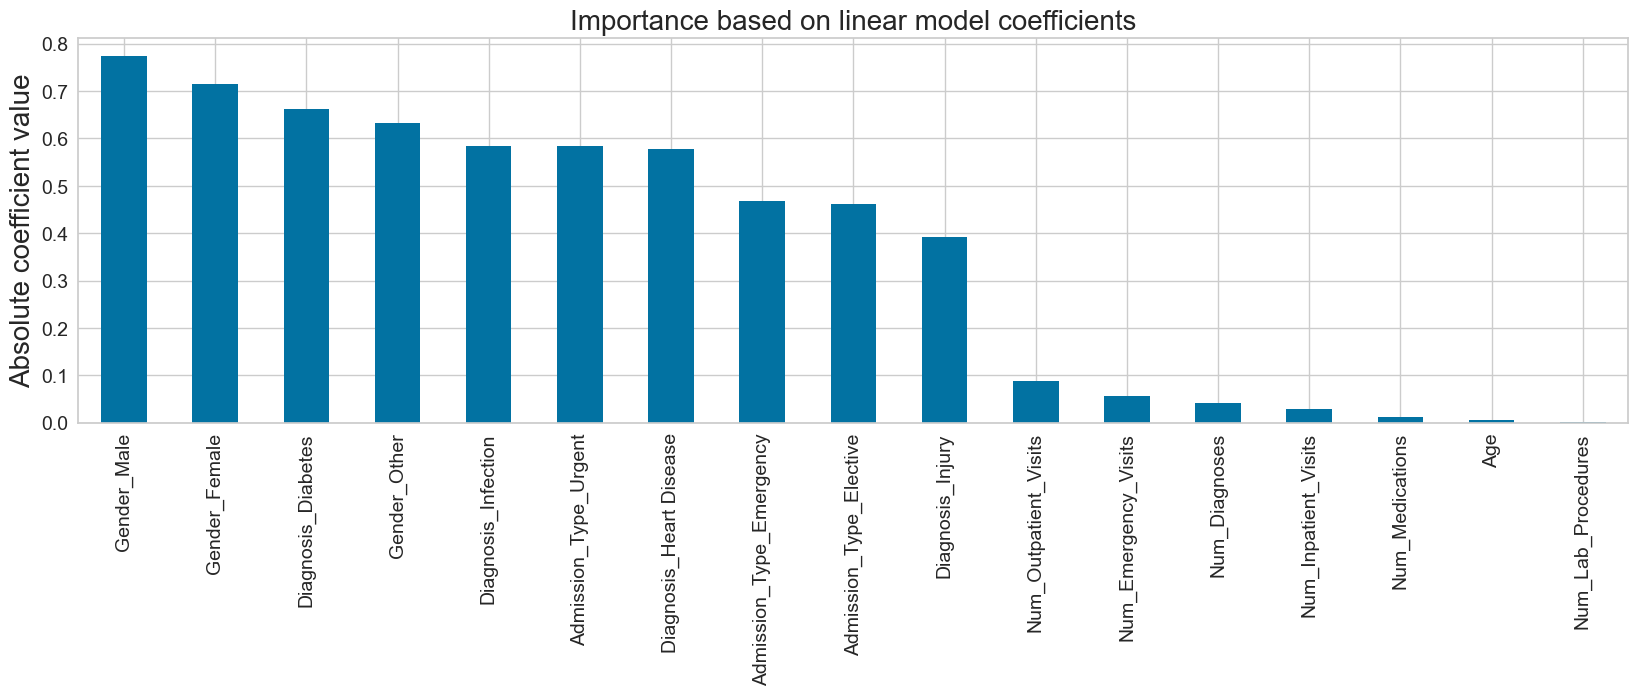

In [141]:
# Logistic Regression Model without applying PCA
clf8=LogisticRegression(random_state=42,max_iter=1000)
clf8.fit(X_train_smote, y_train_smote)

column_names = ['Age', 'Num_Lab_Procedures', 'Num_Medications','Num_Outpatient_Visits','Num_Inpatient_Visits','Num_Emergency_Visits','Num_Diagnoses','Gender_Female','Gender_Male','Gender_Other','Admission_Type_Elective','Admission_Type_Emergency','Admission_Type_Urgent','Diagnosis_Diabetes','Diagnosis_Heart Disease','Diagnosis_Infection','Diagnosis_Injury'] 
X_train_smote_temp = pd.DataFrame(X_train_smote, columns=column_names)

importance = pd.Series(
    data = np.abs(clf8.coef_[0]),
    index = X_train_smote_temp.columns,
)
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(20,5), fontsize=14)
plt.title("Importance based on linear model coefficients", fontsize=20)
plt.ylabel("Absolute coefficient value", fontsize=20)
plt.show()

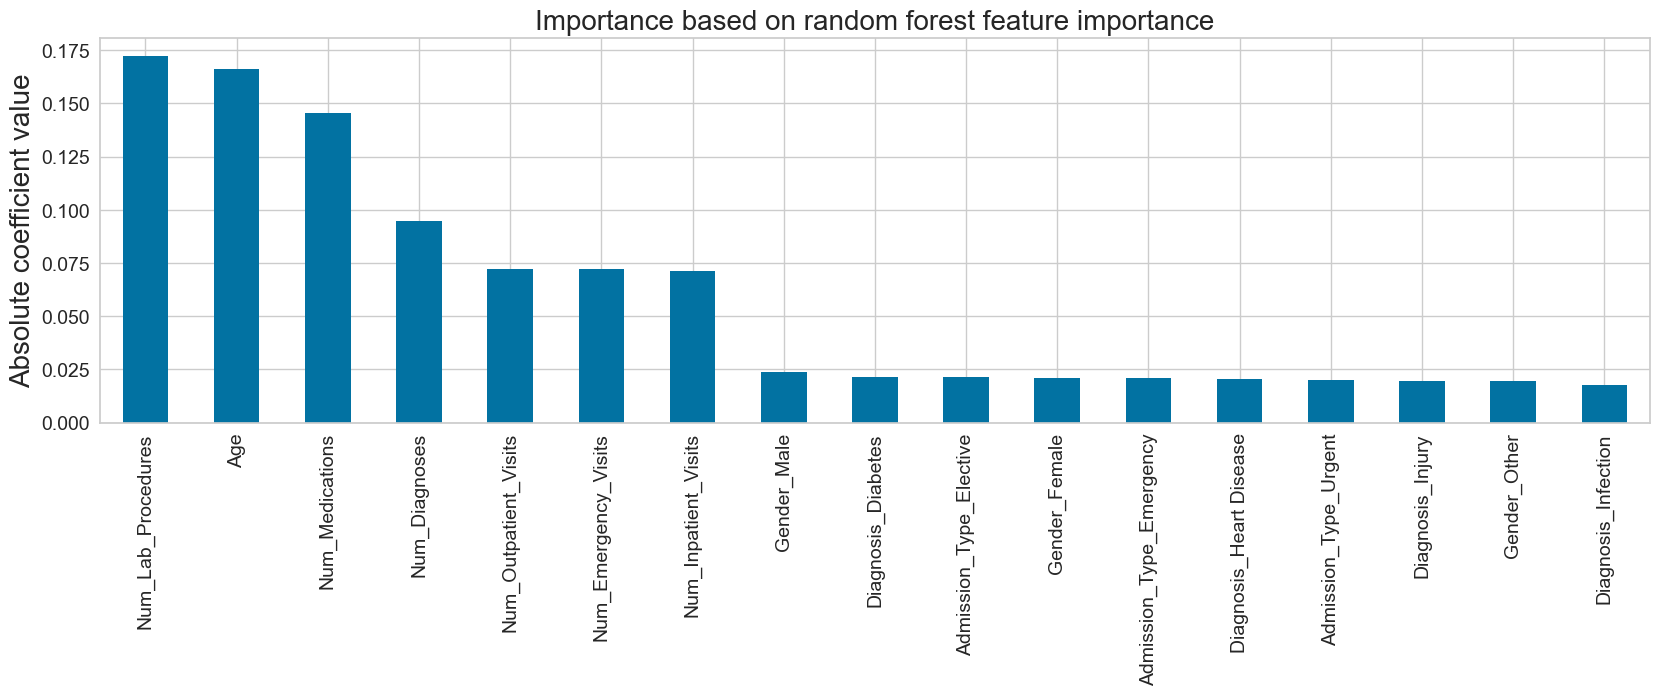

In [142]:
# Random Forest Model without applying PCA
clf9=RandomForestClassifier(n_estimators=100)
clf9.fit(X_train_smote, y_train_smote)

column_names = ['Age', 'Num_Lab_Procedures', 'Num_Medications','Num_Outpatient_Visits','Num_Inpatient_Visits','Num_Emergency_Visits','Num_Diagnoses','Gender_Female','Gender_Male','Gender_Other','Admission_Type_Elective','Admission_Type_Emergency','Admission_Type_Urgent','Diagnosis_Diabetes','Diagnosis_Heart Disease','Diagnosis_Infection','Diagnosis_Injury'] 
X_train_smote_temp = pd.DataFrame(X_train_smote, columns=column_names)

importance = pd.Series(data=clf9.feature_importances_, index=X_train_smote_temp.columns)

importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(20,5), fontsize=14)
plt.title("Importance based on random forest feature importance", fontsize=20)
plt.ylabel("Absolute coefficient value", fontsize=20)
plt.show()

## Final thoughts :
- After applying EDA and feature importance, it is clear that the columns - "Gender", "Diagnosis", "Admission_Type" - majorly contributes to the model built.
- It is evident that the hospital readmissions focuses primarily on these 3 fields. Other fields have a minor impact on the target column (Readmission_Yes).